## MovieLens-100k

Explicit feedback data. No negative sampling is required because there are negative examples in the training data.

Softmax and BPR models are implemented. They are compared to reasonable baselines with ranking metrics.

I use lightning for training.

I only use user/film interactions -- no user/film extra features (in RecBole terms, I implement General Reccommendation model). 

There is a cold start problem with the current implementation. There are no predictions for users outside of the train set.

Including user features (which is straightforward) will help with this.

Including movie features as well will improve recommendation performance.

In [1]:
from typing import Callable
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

class MovieLens(Dataset):
    def __init__(
        self,
        subset_indices=None
    ) -> None:
        super().__init__()
        self.movies = pd.read_csv("./data/ml-latest-small/movies.csv")
        self.ratings = pd.read_csv("./data/ml-latest-small/ratings.csv")
        self.data = self.ratings.join(self.movies, on="movieId", rsuffix="_tmp")
        self.data.drop(columns="movieId_tmp", inplace=True)

        if subset_indices is not None:
            self.data = self.data.loc[subset_indices, :]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data.iloc[index, :]

In [2]:
from torch.utils.data import DataLoader
import torch
from lightning import LightningDataModule
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
from sklearn.preprocessing import LabelEncoder

class MovieLensDataModule(LightningDataModule):
    """
    Preprocesses the data, defines data loader with collators.
    Preprocessing includes:
        - train/val/test partition by timestamp;
        - LabelEncoding for users and items;
        - ratings [0-5] to {0,1}
        - (optionnaly) fuze positive and negative observations -- basically, negative sampling.
            This is required by some models, like BPR

    TODO.2: it should not access ```.data``` field.

    Args:
        LightningDataModule (_type_): _description_
    """
    def __init__(
        self,
        train_batch_size=32, val_batch_size=64, 
        fuze_pos_neg=False,
        val_size=0.2, test_size=0,
    ) -> None:
        super().__init__()
        np.random.seed(42)
        self.dataset = MovieLens()
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.val_size = val_size
        self.test_size = test_size
        self.partition_data()
        self.n_users = len(self.train_dataset.data['userId'].unique())
        self.n_items = len(self.train_dataset.data['movieId'].unique())

        self.preprocess_ids()
        self.preprocess_ratings()
        if fuze_pos_neg:
            self.fuze_pos_neg()

    def partition_data(self):
        train, val, test = self.get_subset_indices()
        self.train_dataset = MovieLens(subset_indices=train)
        self.val_dataset = MovieLens(subset_indices=val)
        self.test_dataset = MovieLens(subset_indices=test)

    def get_subset_indices(
        self,
    ):
        """Partition by timestamp
        """
        # TODO.2
        val_size = self.val_size
        test_size = self.test_size
        sorted_data = self.dataset.data.sort_values(by="timestamp", ascending=True)
        n = len(sorted_data)
        train_size = int(np.ceil((1-val_size-test_size) * n))
        val_size = int(np.floor(val_size * n))
        test_size = int(np.floor(test_size * n))
        return (
            # TODO.2
            sorted_data.index[range(train_size)], 
            sorted_data.index[range(train_size, train_size + val_size)], 
            sorted_data.index[range(train_size + val_size, train_size + val_size + test_size)]
        )
    
    def preprocess_ids(self):
        user_id_encoder = LabelEncoder()
        movie_id_encoder = LabelEncoder()
        user_id_encoder.fit(self.train_dataset.data['userId'])
        movie_id_encoder.fit(self.train_dataset.data['movieId'])

        for col, encoder in [('userId', user_id_encoder), ('movieId', movie_id_encoder)]:
            # TODO: bad
            self.val_dataset.data = self.val_dataset.data[
                self.val_dataset.data[col].isin(encoder.classes_)
            ]
            self.test_dataset.data = self.test_dataset.data[
                self.test_dataset.data[col].isin(encoder.classes_)
            ]
            #
            for ds in [self.train_dataset, self.val_dataset, self.test_dataset]:
                ds.data[col] = encoder.transform(ds.data[col])
    
    def preprocess_ratings(self):
        for ds in [self.train_dataset, self.val_dataset, self.test_dataset]:
            ds.data['rating'] = (ds.data['rating'] > 3).astype(int)

    def fuze_pos_neg(self):
        # todo: should really exclude
        self.train_dataset.data['movieId_neg'] = np.random.choice(range(self.n_items), size=len(self.train_dataset))
        self.val_dataset.data['movieId_neg'] = np.random.choice(range(self.n_items), size=len(self.val_dataset))

    def setup(self, stage: str) -> None:
        pass
    
    def collate_fn(self, batch):
        dict = pd.DataFrame(batch).to_dict()
        dict = {k: torch.tensor(list(v.values())) for k, v in dict.items() if k in ['userId', 'movieId', 'rating', 'movieId_neg']}
        return dict
    
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            dataset=self.train_dataset, 
            batch_size=self.train_batch_size, 
            collate_fn=self.collate_fn
        )
    
    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            dataset=self.val_dataset, 
            batch_size=self.val_batch_size, 
            collate_fn=self.collate_fn
        )
    
    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            dataset=self.test_dataset, 
            batch_size=self.val_batch_size, 
            collate_fn=self.collate_fn
        )

In [4]:
from copy import deepcopy
from torchmetrics import F1Score, MetricCollection
import torch.nn as nn

from utils import BaseModel

class SoftmaxModel(BaseModel):
    """https://developers.google.com/machine-learning/recommendation/dnn/softmax

    Args:
        LightningModule (_type_): _description_
    """
    def __init__(
        self, 
        n_user, n_items,
        hidden_dim=600,
        emb_dim=300,
        *args,
        **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)
        self.train_metrics = MetricCollection({
            "f1": F1Score(task='binary')
        })
        self.val_metrics = deepcopy(self.train_metrics)
        self.test_metrics = deepcopy(self.train_metrics)

        self.emb_dim = emb_dim
        self.user_embedding = nn.Sequential(
            nn.Embedding(n_user, hidden_dim),
            # nn.Linear(hidden_dim, emb_dim),
            nn.Linear(hidden_dim, hidden_dim + (emb_dim - hidden_dim) // 2),
            nn.BatchNorm1d(hidden_dim + (emb_dim - hidden_dim) // 2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim + (emb_dim - hidden_dim) // 2, emb_dim)
        )
        self.item_embedding = nn.Sequential(
            nn.Embedding(n_items, hidden_dim),
            # nn.Linear(hidden_dim, emb_dim),
            nn.Linear(hidden_dim, hidden_dim + (emb_dim - hidden_dim) // 2),
            nn.BatchNorm1d(hidden_dim + (emb_dim - hidden_dim) // 2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim + (emb_dim - hidden_dim) // 2, emb_dim)
        )
        self.loss = nn.BCELoss()

    def embed_user(self, batch):
        """To add extra features, concat them before the linear layers"""
        return self.user_embedding(batch['userId'])

    def embed_item(self, batch):
        return self.item_embedding(batch['movieId'])
    
    def common_step(self, batch):
        bs = len(batch['rating'])
        user_emb = self.embed_user(batch) # ~ (batch_size, emb_dim)
        item_emb = self.embed_item(batch) # 
        # dot products for every pair in batch
        y_hat = torch.bmm(
            user_emb.view(bs, 1, self.emb_dim), 
            item_emb.view(bs, self.emb_dim, 1)
        ) # ~ (bs, 1)
        y_hat = y_hat.flatten()
        y_hat = (
            y_hat / 
            (torch.norm(user_emb, dim=1) * torch.norm(item_emb, dim = 1))
        )
        return y_hat.sigmoid()

In [5]:
from lightning.pytorch.utilities.types import STEP_OUTPUT
from torch.nn.init import xavier_normal_

class BPRLoss(nn.Module):
    """ BPRLoss, based on Bayesian Personalized Ranking

    Args:
        - gamma(float): Small value to avoid division by zero

    Shape:
        - Pos_score: (N)
        - Neg_score: (N), same shape as the Pos_score
        - Output: scalar.

    Examples::

        >>> loss = BPRLoss()
        >>> pos_score = torch.randn(3, requires_grad=True)
        >>> neg_score = torch.randn(3, requires_grad=True)
        >>> output = loss(pos_score, neg_score)
        >>> output.backward()
    """

    def __init__(self, gamma=1e-10):
        super(BPRLoss, self).__init__()
        self.gamma = gamma

    def forward(self, pos_score, neg_score):
        loss = -torch.log(self.gamma + torch.sigmoid(pos_score - neg_score)).mean()
        return loss


class BPR(BaseModel):
    """https://arxiv.org/pdf/1205.2618.pdf

    Args:
        BaseModel (_type_): _description_
    """
    
    def __init__(self, *args, n_user, n_items, emb_dim=64, learning_rate=0.0001, **kwargs) -> None:
        super().__init__(*args, learning_rate=learning_rate, **kwargs)
        self.n_users = n_user
        self.n_items = n_items
        self.emb_dim = emb_dim

        self.user_embedding = nn.Embedding(self.n_users, self.emb_dim)
        self.item_embedding = nn.Embedding(self.n_items, self.emb_dim)
        self.loss = BPRLoss()

        # parameters initialization
        xavier_normal_(self.user_embedding.weight.data)
        xavier_normal_(self.item_embedding.weight.data)

    def embed_user(self, user):
        return self.user_embedding(user)

    def embed_item(self, item):
        return self.item_embedding(item)

    def forward(self, user, item):
        user_e = self.embed_user(user)
        item_e = self.embed_item(item)
        return user_e, item_e

    def common_step(self, batch):
        user = batch['userId']
        pos = batch['movieId']
        neg = batch['movieId_neg']

        user_e, pos_e = self.forward(user, pos)
        neg_e = self.embed_item(neg)
        pos_item_score, neg_item_score = torch.mul(user_e, pos_e).sum(dim=1), torch.mul(user_e, neg_e).sum(dim=1)
        return pos_item_score, neg_item_score
    
    def training_step(self, batch, _) -> STEP_OUTPUT:
        pos, neg = self.common_step(batch)
        loss = self.loss(pos, neg)
        self.log_dict({"train_loss": loss})
        return loss
    
    def validation_step(self, batch, _) -> STEP_OUTPUT | None:
        pos, neg = self.common_step(batch)
        loss = self.loss(pos, neg)
        self.log("val_loss", loss)
        return loss

## Train Softmax

In [21]:
dm = MovieLensDataModule(train_batch_size=128, val_batch_size=256)

In [22]:
model = SoftmaxModel(n_items=dm.n_items, n_user=dm.n_users, learning_rate=1e-4, emb_dim=64, hidden_dim=128)

In [23]:
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

trainer = Trainer(
    max_epochs=-1,
    logger=TensorBoardLogger(save_dir="logs", name="softmax"), 
    callbacks=[ModelCheckpoint(
        "./checkpoints/", 
        monitor="val_f1", 
        save_top_k=1, 
        mode="max", 
        every_n_epochs=1, 
        filename='{epoch}-{val_f1:.2f}',
        save_last=True
    )],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(model=model, datamodule=dm)

/home/leo/miniconda3/envs/ml/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/leo/miscellaneous/movies/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | train_metrics  | MetricCollection | 0     
1 | val_metrics    | MetricCollection | 0     
2 | test_metrics   | MetricCollection | 0     
3 | user_embedding | Sequential       | 85.6 K
4 | item_embedding | Sequential       | 1.0 M 
5 | loss           | BCELoss          | 0     
----------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.445     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/leo/miniconda3/envs/ml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/leo/miniconda3/envs/ml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/leo/miniconda3/envs/ml/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Train BPR

In [30]:
dm = MovieLensDataModule(train_batch_size=128, val_batch_size=256, fuze_pos_neg=True)
bpr = BPR(n_items=dm.n_items, n_user=dm.n_users, learning_rate=1e-4, emb_dim=64)

In [7]:
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

trainer = Trainer(
    max_epochs=-1,
    logger=TensorBoardLogger(save_dir="logs", name="bpr"), 
    callbacks=[ModelCheckpoint(
        "./checkpoints/", 
        monitor="val_loss", 
        save_top_k=1, 
        mode="min", 
        every_n_epochs=1, 
        filename='{epoch}-{val_loss:.2f}',
        save_last=True
    )],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(datamodule=dm, model=bpr)

Missing logger folder: logs/bpr
/home/leo/miniconda3/envs/ml/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/leo/miscellaneous/movies/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 33.4 K
1 | item_embedding | Embedding | 503 K 
2 | loss           | BPRLoss   | 0     
---------------------------------------------
536 K     Trainable params
0         Non-trainable params
536 K     Total params
2.148     Total estimated model params size (MB)
2023-05-10 10:31:53.415688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.

Sanity Checking: 0it [00:00, ?it/s]

/home/leo/miniconda3/envs/ml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/leo/miniconda3/envs/ml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/leo/miniconda3/envs/ml/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## ranking metrics

In [32]:
train = dm.train_dataset.data
val = dm.val_dataset.data

In [33]:
n_users = dm.n_users
n_movies = dm.n_items

In [29]:
model = model.load_from_checkpoint("./checkpoints/epoch=6-val_f1=0.86.ckpt", n_user=n_users, n_items=n_movies, emb_dim=64, hidden_dim=128).eval()
bpr = bpr.load_from_checkpoint("./checkpoints/epoch=51-val_loss=0.54.ckpt", n_user=n_users, n_items=n_movies).eval()

In [43]:
def remove_train_items(preds, k, users=range(n_users)):
    """Do not let model predict what user has already seen

    Args:
        preds (_type_): _description_
        k (_type_): _description_
        users (_type_, optional): _description_. Defaults to range(n_users).

    Returns:
        _type_: _description_
    """
    new_preds = np.zeros((preds.shape[0], k), dtype=np.int)
    for user, data in train.groupby('userId'):
        if user in users:
            user_preds = preds[users.index(user)]
            new_preds[users.index(user)] = user_preds[~np.in1d(user_preds, data.movieId)][:k]
    return new_preds


def get_bpr(encoded_user_ids, k):
    """

    Args:
        encoded_user_ids (_type_): _description_
        k (_type_): _description_

    Returns:
        _type_: _description_
    """
    movies_embeddings = bpr.embed_item(torch.tensor(range(n_movies)))
    user_embeddings = bpr.embed_user(torch.tensor(encoded_user_ids))
    res = (user_embeddings @ movies_embeddings.T)
    preds = np.argsort(-res.detach().numpy(), axis=1)
    preds = remove_train_items(preds, k, users=encoded_user_ids)
    return preds


def get_softmax(encoded_user_ids, k):
    """Angles

    Args:
        encoded_user_ids (_type_): _description_
        k (_type_): _description_

    Returns:
        _type_: _description_
    """
    movies_embeddings = model.embed_item({"movieId": torch.tensor(range(n_movies))})
    user_embeddings = model.embed_user({"userId": torch.tensor(encoded_user_ids)})
    movies_norms = torch.norm(movies_embeddings, dim=-1)
    user_norms = torch.norm(user_embeddings, dim=-1)
    normalization_factor = 1 / torch.outer(user_norms, movies_norms)
    res = (user_embeddings @ movies_embeddings.T) * normalization_factor
    # res = (user_embeddings @ movies_embeddings.T)
    preds = np.argsort(-res.detach().numpy(), axis=1)
    preds = remove_train_items(preds, k, users=encoded_user_ids)
    return preds


def get_random_preds(k=10):
    preds = np.tile(np.arange(n_movies), (n_users, 1))
    for i in range(n_users):
        rand_perm = np.random.permutation(n_movies)
        preds[i] = preds[i][rand_perm]

    preds = remove_train_items(preds, k)
    return preds


def get_toppop_preds(freq=10, k=10):
    mean_rating = train.groupby('movieId').rating.mean()
    mean_rating = mean_rating[train.groupby('movieId').size() >= freq]
    preds = np.array(mean_rating.sort_values(ascending=False).index)
    preds = np.tile(preds, (n_users, 1))
    preds = remove_train_items(preds, k)
    return preds


def MAP_k(y_true, y_pred, k=10):
    map_k, count = 0, 0
    for relevant, predicted in zip(y_true, y_pred):
        if not relevant:
            continue
        correct = np.isin(predicted[:k], relevant)
        map_k += (correct / np.arange(1, k + 1)).sum() / (1 / np.arange(1, len(relevant) + 1)).sum()
        count += 1
    map_k = map_k / count
    return map_k

In [44]:
"""I do not use separate test set because I haven't uset val much
"""
users = []
true_relevant = []
for user, data in val[val.rating == 1].groupby('userId'):
    users.append(user)
    true_relevant += [data.movieId.tolist()]

In [46]:
ks = np.arange(1, 31)
softmax_predictions = get_softmax(users, k=ks[-1])
bpr_predictions = get_bpr(users, k=ks[-1])
random_preds = get_random_preds(k=ks[-1])
top_preds = get_toppop_preds(freq=10, k=ks[-1])

random_map_k = [MAP_k(true_relevant, random_preds, k=k) for k in ks]
top_map_k = [MAP_k(true_relevant, top_preds, k=k) for k in ks]
softmax_map_k = [MAP_k(true_relevant, softmax_predictions, k=k) for k in ks]
bpr_map_k = [MAP_k(true_relevant, bpr_predictions, k=k) for k in ks]

/tmp/ipykernel_7882/2657879611.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  new_preds = np.zeros((preds.shape[0], k), dtype=np.int)
/tmp/ipykernel_7882/2657879611.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

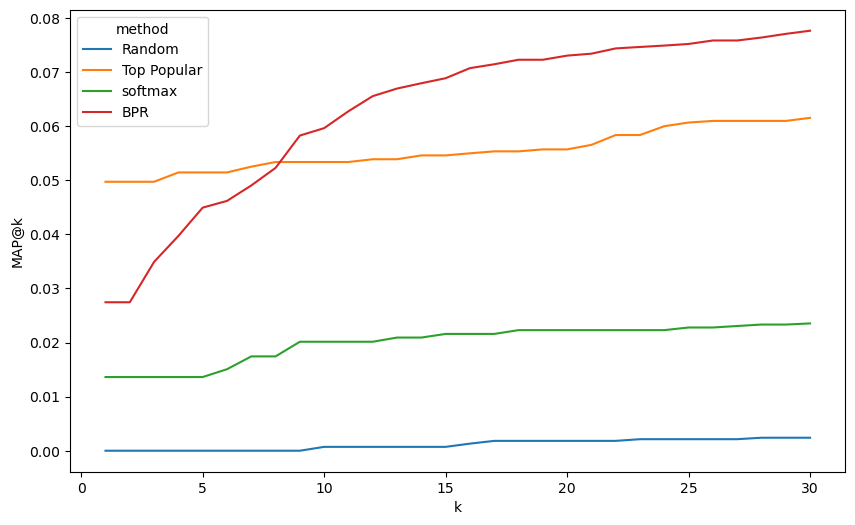

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(ks, random_map_k, label='Random')
plt.plot(ks, top_map_k, label='Top Popular')
plt.plot(ks, softmax_map_k, label='softmax')
plt.plot(ks, bpr_map_k, label='BPR')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()  